# RNN Based Language Model From Scratch

In this notebook, I have tried to implement the part 3 of Andrej Karpathy's `Makemore` series.

In [1]:
# imports
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open(r'../names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [ ]:
# Building vocabulary and Basic Character encoding and decoding

chars = sorted(list(set(''.join(words)))) # Get all the unique chars in sorted order

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("itos: ", itos)
print("Vocab Size is: ", vocab_size)

itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size is:  27


### Building the Dataset

Since this is a character level language model, we will be predicting the next in a sequence of some `block_size` elements. That is, if `block_size=3`, then our model will be predicting the fourth letter in a sequence of three characters. You can think of block size as the context length.

In [9]:
block_size = 3 

def build_dataset(words):
    X, Y = [ ], [ ]

    for w in words:
        context = [0] * block_size # For start of the word, have a padded context
        for char in w + ".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [10]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words=words[:n1])
X_val, Y_val = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

print("Train sizes: ", X_train.shape, Y_train.shape)
print("Validation Sizes: ", X_val.shape, Y_val.shape)
print("Test Sizes: ", X_test.shape, Y_test.shape)

Train sizes:  torch.Size([182437, 3]) torch.Size([182437])
Validation Sizes:  torch.Size([22781, 3]) torch.Size([22781])
Test Sizes:  torch.Size([22928, 3]) torch.Size([22928])


### Revisiting MLP Code

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, b1, W2, b2]
print("Total Parameters: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total Parameters:  11897


In [17]:
epochs = 20000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  20000: 25.5262
   1000/  20000: 3.5105
   2000/  20000: 2.6203
   3000/  20000: 3.1271
   4000/  20000: 2.8015
   5000/  20000: 2.7176
   6000/  20000: 2.8684
   7000/  20000: 2.6495
   8000/  20000: 2.3124
   9000/  20000: 2.6709
  10000/  20000: 1.8494
  11000/  20000: 2.1175
  12000/  20000: 2.2411
  13000/  20000: 2.2771
  14000/  20000: 2.7150
  15000/  20000: 2.2039
  16000/  20000: 2.5933
  17000/  20000: 2.4171
  18000/  20000: 2.2371
  19000/  20000: 2.6148


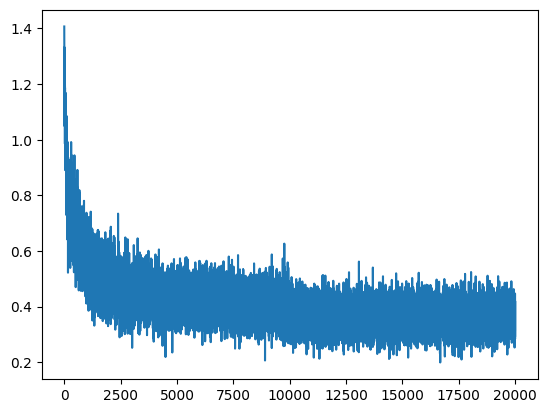

In [18]:
plt.plot(lossi)

In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [X_train, Y_train], 
        'test': [X_test, Y_test], 
        'val': [X_val, Y_val]
    }[split]

    embeddings = C[x]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1)
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y) # PyTorch will apply softmax internally

    print(f"For {split}, loss was: {loss.item()}")

split_loss('train')
split_loss('val')

For train, loss was: 2.3057711124420166
For val, loss was: 2.3421437740325928


##### Predictions Using the Model

In [24]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = [ ]
    context = [0] * block_size

    while True:

        embeddings = C[torch.tensor([context])]
        h = torch.tanh(embeddings.view(1, -1) @ W1  + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [idx]

        out.append(idx)

        if idx == 0:
            break

    print("".join(itos[i] for i in out))

mri.
ammyanniee.
mad.
ryah.
rethan.
engramo.
azeeph.
eliigell.
jen.
ede.
sustanar.
kayziostara.
noshurergahiries.
kinie.
jelinnn.
pucanu.
mayve.
ryy.
juliel.
ylay.


### Pro Tip:

When training neural networks, you should always have a rough intuition of what the loss should be at initialization. Think in terms of what the problem is and what the model setup is to get an idea of this. Do some research online also. For example, in the MLP case, **at initialization**, we don't have any reason to believe that our model should assign higher probability to any of the characters. Thus, initially, the probabilities assigned to each character should be equal- $1/27$. Since the loss is negative log likelihood, the loss we should expect at initialization is: $-torch.tensor(1/27.0).log()=3.295$

### Batch Normalization


Notice how the actual loss is way worse than the expected loss. So, there's something wrong with the initialization.